In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded=files.upload()

Saving vertopal.com_jsonformatter.json to vertopal.com_jsonformatter.json


In [3]:
#create kaggle folder
! mkdir ~/.kaggle

In [4]:
#copy json file to folder
! cp vertopal.com_jsonformatter.json ~/.kaggle/

In [5]:
!mv /content/vertopal.com_jsonformatter.json /root/.kaggle/kaggle.json

In [6]:
#permission for JSON to act
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                         Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          19607        424  1.0              
sahirmaharajj/school-student-daily-attendance                  School Student Daily Attendance                      2MB  2024-04-29 19:29:56           4823        101  1.0              
jainaru/diversity-in-tech-companies                            Diversity in Tech Companies                          1KB  2024-05-14 19:45:37            412         24  1.0              
jainaru/thyroid-disease-data                                   Thyroid

In [8]:
!kaggle datasets download -d landrykezebou/uot32-underwater-object-tracking-dataset

Dataset URL: https://www.kaggle.com/datasets/landrykezebou/uot32-underwater-object-tracking-dataset
License(s): other
100% 3.39G/3.40G [01:56<00:00, 18.9MB/s]
100% 3.40G/3.40G [01:56<00:00, 31.4MB/s]


In [9]:
!unzip uot32-underwater-object-tracking-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: SeaTurtle1/img/632.jpg  
  inflating: SeaTurtle1/img/633.jpg  
  inflating: SeaTurtle1/img/634.jpg  
  inflating: SeaTurtle1/img/635.jpg  
  inflating: SeaTurtle1/img/636.jpg  
  inflating: SeaTurtle1/img/637.jpg  
  inflating: SeaTurtle1/img/638.jpg  
  inflating: SeaTurtle1/img/639.jpg  
  inflating: SeaTurtle1/img/64.jpg   
  inflating: SeaTurtle1/img/640.jpg  
  inflating: SeaTurtle1/img/641.jpg  
  inflating: SeaTurtle1/img/642.jpg  
  inflating: SeaTurtle1/img/643.jpg  
  inflating: SeaTurtle1/img/644.jpg  
  inflating: SeaTurtle1/img/645.jpg  
  inflating: SeaTurtle1/img/646.jpg  
  inflating: SeaTurtle1/img/647.jpg  
  inflating: SeaTurtle1/img/648.jpg  
  inflating: SeaTurtle1/img/649.jpg  
  inflating: SeaTurtle1/img/65.jpg   
  inflating: SeaTurtle1/img/650.jpg  
  inflating: SeaTurtle1/img/651.jpg  
  inflating: SeaTurtle1/img/652.jpg  
  inflating: SeaTurtle1/img/653.jpg  
  inflating: SeaTurtle1/img/654.jpg  

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

# Define the SRCNN model architecture
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations for training images
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

# Load the dataset for training
root_dir_train = "/content/Octopus1/img"
dataset_train = CustomImageDataset(root_dir=root_dir_train, transform=transform_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

# Initialize the SRCNN model
model = SRCNN()

# Specify the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optionally move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs in dataloader_train:
        inputs = inputs.to(device)  # Move inputs to GPU if available
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(dataloader_train)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

    # Append epoch loss to the list
    train_losses.append(epoch_loss)

# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Graph')
plt.show()

# Define transformations for video frames
transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

# Load the video
video_path = "/content/Octopus1/Octopus1.mp4"
cap = cv2.VideoCapture(video_path)

# Variables for storing enhancement metrics
original_psnr = []
enhanced_psnr = []
original_ssim = []
enhanced_ssim = []

# Variables for measuring time
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_time = frame_count / fps

# Process video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert frame to tensor and enhance using SRCNN model
    frame_tensor = torch.unsqueeze(transform_video(frame_rgb), 0).to(device)
    with torch.no_grad():
        enhanced_frame_tensor = model(frame_tensor)

    # Convert enhanced frame tensor to numpy array
    enhanced_frame = (enhanced_frame_tensor.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # Resize the enhanced frame to match the dimensions of the original frame
    enhanced_frame = cv2.resize(enhanced_frame, (frame_rgb.shape[1], frame_rgb.shape[0]))

    # Calculate PSNR and SSIM for original and enhanced frames
    original_psnr.append(PSNR(frame_rgb, frame_rgb))
    enhanced_psnr.append(PSNR(frame_rgb, enhanced_frame))
    original_ssim.append(SSIM(frame_rgb, frame_rgb, channel_axis=-1))
    enhanced_ssim.append(SSIM(frame_rgb, enhanced_frame, channel_axis=-1))

    # Save enhanced frame (optional)
    cv2.imwrite('enhanced_frames/frame_{}.jpg'.format(frame_count), cv2.cvtColor(enhanced_frame, cv2.COLOR_RGB2BGR))

# Release the video capture object
cap.release()

# Calculate average improvement in PSNR and SSIM
avg_psnr_improvement = np.mean(np.array(enhanced_psnr) - np.array(original_psnr))
avg_ssim_improvement = np.mean(np.array(enhanced_ssim) - np.array(original_ssim))

# Print results
print("Average PSNR improvement:", avg_psnr_improvement)
print("Average SSIM improvement:", avg_ssim_improvement)
print("Total time of the video (seconds):", total_time)

# Plot enhancement metrics
plt.figure(figsize=(10, 5))
plt.plot(original_psnr, label='Original PSNR')
plt.plot(enhanced_psnr, label='Enhanced PSNR')
plt.xlabel('Frame')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Improvement')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(original_ssim, label='Original SSIM')
plt.plot(enhanced_ssim, label='Enhanced SSIM')
plt.xlabel('Frame')
plt.ylabel('SSIM')
plt.title('SSIM Improvement')
plt.legend()
plt.show()

# Show some sample enhanced images
sample_images = next(iter(dataloader_train)) # Get a batch of input images
sample_images = sample_images.to(device)
with torch.no_grad():
    enhanced_sample_images = model(sample_images)  # Get enhanced images

# Display original and enhanced images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
for i in range(4):
    axes[0, i].imshow(sample_images[i].permute(1, 2, 0).cpu().numpy())
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    axes[1, i].imshow(enhanced_sample_images[i].permute(1, 2, 0).cpu().numpy())
    axes[1, i].set_title('Enhanced')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Epoch 1/50
13/13 [==============================] - 53s 2s/step - loss: 0.0835 - val_loss: 0.0833
Epoch 2/50
13/13 [==============================] - 7s 533ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 3/50
13/13 [==============================] - 7s 540ms/step - loss: 0.0834 - val_loss: 0.0832
Epoch 4/50
13/13 [==============================] - 7s 569ms/step - loss: 0.0834 - val_loss: 0.0832
Epoch 5/50
13/13 [==============================] - 7s 571ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 6/50
13/13 [==============================] - 7s 569ms/step - loss: 0.0834 - val_loss: 0.0832
Epoch 7/50
13/13 [==============================] - 7s 540ms/step - loss: 0.0834 - val_loss: 0.0832
Epoch 8/50
13/13 [==============================] - 7s 560ms/step - loss: 0.0834 - val_loss: 0.0832
Epoch 9/50
13/13 [==============================] - 7s 556ms/step - loss: 0.0834 - val_loss: 0.0832
Epoch 10/50
13/13 [==============================] - 7s 533ms/step - loss: 0.0834 - val_loss: 0.0833
E

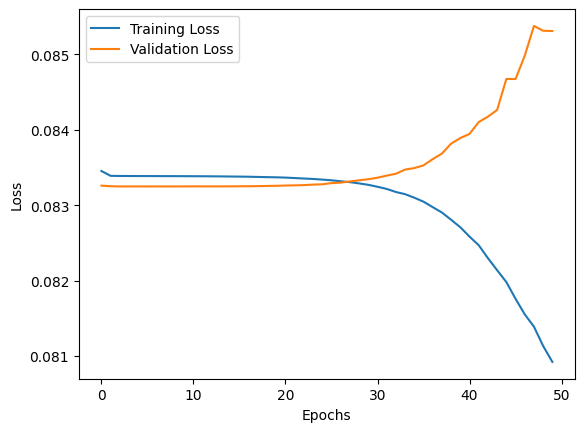

1/1 [==============================] - 9s 9s/step
PSNR: 10.674974422318446, SSIM: 0.03942884256535211


<ipython-input-11-3665217d614f>:91: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(y_test.squeeze(), y_pred.squeeze())
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Define U-Net architecture
def unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Define loss function
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load dataset and preprocess
def load_data():
    # Code for loading and preprocessing the dataset
    X_train = np.random.rand(100, 256, 256, 3)  # Example random data
    y_train = np.random.rand(100, 256, 256, 1)  # Example random data
    X_val = np.random.rand(20, 256, 256, 3)     # Example random data
    y_val = np.random.rand(20, 256, 256, 1)     # Example random data
    return X_train, y_train, X_val, y_val

# Train model
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=8):
    model.compile(optimizer=Adam(), loss=custom_loss)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return history

# Plot training history
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    psnr_value = psnr(y_test.squeeze(), y_pred.squeeze())
    ssim_value = ssim(y_test.squeeze(), y_pred.squeeze())
    return psnr_value, ssim_value

# Full pipeline
if __name__ == "__main__":
    # Load data
    X_train, y_train, X_val, y_val = load_data()

    # Create model
    input_shape = X_train[0].shape
    model = unet(input_shape)

    # Train model
    history = train_model(model, X_train, y_train, X_val, y_val)

    # Plot training history
    plot_history(history)

    # Evaluate model
    X_test, y_test = np.random.rand(10, 256, 256, 3), np.random.rand(10, 256, 256, 1)  # Example random test data
    psnr_value, ssim_value = evaluate_model(model, X_test, y_test)
    print(f"PSNR: {psnr_value}, SSIM: {ssim_value}")


<ipython-input-16-893566921220>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(original_image, enhanced_image, multichannel=True)


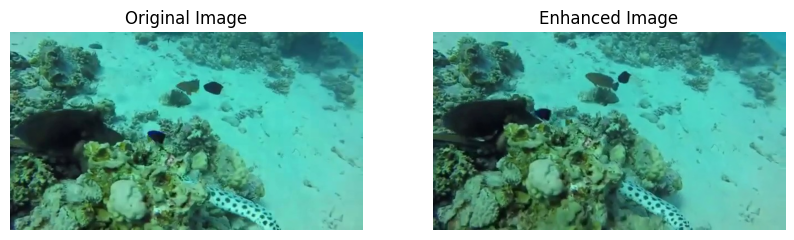

PSNR: 16.569335593724343
SSIM: 0.386904774643094


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Read the original and enhanced images
original_image = cv2.imread("/content/Octopus1/img/1.jpg")
enhanced_image = cv2.imread('/content/Octopus1/img/10.jpg')

# Check if the images are None
if original_image is None or enhanced_image is None:
    print("Error: Unable to read the images.")
else:
    # Calculate PSNR and SSIM
    psnr_score = psnr(original_image, enhanced_image)
    ssim_score = ssim(original_image, enhanced_image, multichannel=True)

    # Plot images and metrics
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Enhanced Image')
    axs[1].axis('off')
    plt.show()

    # Print PSNR and SSIM
    print('PSNR:', psnr_score)
    print('SSIM:', ssim_score)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_39[0][0]']           
 g2D)                                                                                       

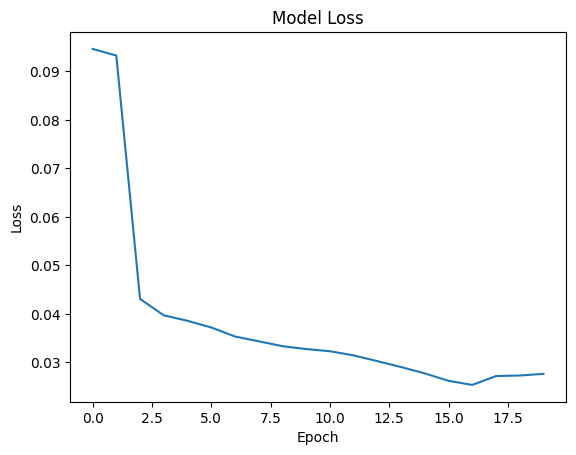

1/1 [==============================] - 0s 252ms/step


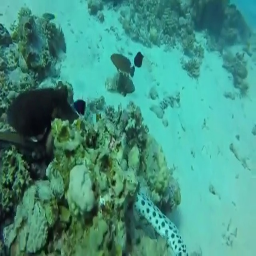

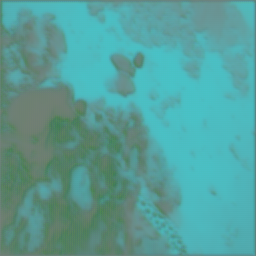

1/1 [==============================] - 0s 22ms/step


ValueError: x and y must have same first dimension, but have shapes (20,) and (3,)

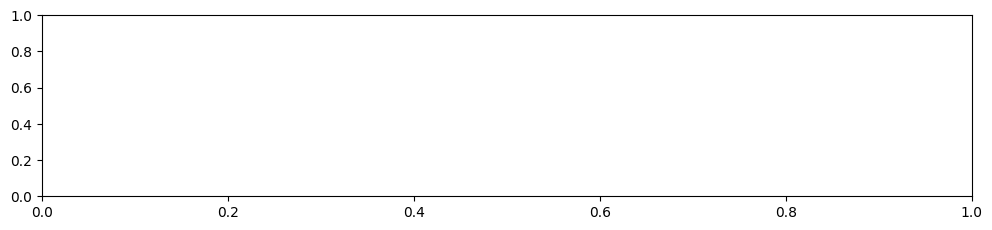

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from google.colab.patches import cv2_imshow

# Define U-Net model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Load the image dataset
def load_dataset(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256)) / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Train the U-Net model
def train_model(model, images, epochs):
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(images, images, epochs=epochs, batch_size=16, shuffle=True)
    return history

# Display original and enhanced images
def display_results(original_image, enhanced_image):
    original_image = cv2.convertScaleAbs(original_image, alpha=255.0)
    enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=255.0)
    cv2_imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))
    cv2_imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR))

# Compute metrics for all images in the dataset
def compute_metrics(original_images, enhanced_images):
    ssim_scores = []
    psnr_scores = []
    mse_scores = []

    for i in range(len(original_images)):
        original_image = cv2.cvtColor(np.uint8(original_images[i] * 255), cv2.COLOR_RGB2GRAY)
        enhanced_image = cv2.cvtColor(np.uint8(enhanced_images[i] * 255), cv2.COLOR_RGB2GRAY)

        ssim_score = ssim(original_image, enhanced_image)
        psnr_score = psnr(original_image, enhanced_image)
        mse_score = np.mean((original_image - enhanced_image) ** 2)

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        mse_scores.append(mse_score)

    return ssim_scores, psnr_scores, mse_scores

# Plot SSIM, PSNR, and MSE scores
def plot_metrics(ssim_scores, psnr_scores, mse_scores, epochs):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(np.arange(1, epochs+1), ssim_scores, marker='o', linestyle='-')
    plt.title('SSIM Scores')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')

    plt.subplot(3, 1, 2)
    plt.plot(np.arange(1, epochs+1), psnr_scores, marker='o', linestyle='-')
    plt.title('PSNR Scores')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')

    plt.subplot(3, 1, 3)
    plt.plot(np.arange(1, epochs+1), mse_scores, marker='o', linestyle='-')
    plt.title('MSE Scores')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')

    plt.tight_layout()
    plt.show()

# Load the dataset
image_paths = ["/content/Octopus1/img/10.jpg", "/content/Octopus1/img/1.jpg", "/content/Octopus1/img/1000.jpg"]
images = load_dataset(image_paths)

# Build and summarize the U-Net model
model = build_unet((256, 256, 3))
model.summary()

# Train the model
epochs = 20  # Increase the number of epochs for better training
history = train_model(model, images, epochs=epochs)

# Display loss curves
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Display results for the first image
original_image = images[0]
enhanced_image = model.predict(np.expand_dims(original_image, axis=0))[0]
display_results(original_image, enhanced_image)

# Compute metrics for all images in the dataset
ssim_scores, psnr_scores, mse_scores = compute_metrics(images, model.predict(images))

# Plot SSIM, PSNR, and MSE scores
plot_metrics(ssim_scores, psnr_scores, mse_scores, epochs=epochs)
